# Load data into Spark DataFrame

In [1]:
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = 'pyspark-shell'

In [2]:
import findspark

In [3]:
#findspark.init('/path_to_spark/spark-x.x.x-bin-hadoopx.x')
findspark.init('/Users/xuejiwang/spark/spark-2.3.2-bin-hadoop2.7')

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F

In [5]:
spark = SparkSession.builder.appName("basics").getOrCreate()

In [6]:
# We use matplotlib for plotting
import matplotlib.pyplot as plt

# This statement allow to display plot without asking to
%matplotlib inline

In [7]:
df = spark.read.csv('/Users/xuejiwang/Documents/dev/MusicBox/data/event_ds.csv',header=True).cache()
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [13]:
df.count()

12269414

In [9]:
df.printSchema()

root
 |-- uid: string (nullable = true)
 |-- event: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- date: string (nullable = true)



In [10]:
# create new or overwrite original field with withColumn
df = df.withColumn('date',F.col('date').cast('date'))
df

DataFrame[uid: string, event: string, song_id: string, date: date]

In [11]:
df.show()

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168551042|    P|  505355|2017-03-30|
|168551430|    P| 1179220|2017-03-30|
|168550728|    P|  285233|2017-03-30|
|168551408|    P|15750838|2017-03-30|
|168551179|    P|23485496|2017-03-30|
|168551546|    P| 1474915|2017-03-30|
|168551626|    P| 8131487|2017-03-30|
|168542680|    P|       0|2017-03-30|
|168551166|    P| 1244660|2017-03-30|
|168551166|    P|  945320|2017-03-30|
|168551495|    P|22797719|2017-03-30|
|168551357|    P|23497506|2017-03-30|
|168551182|    P|23491653|2017-03-30|
|168539955|    P|12913682|2017-03-30|
|168551166|    P|  169744|2017-03-30|
|168551197|    P| 7078121|2017-03-30|
|168548246|    P|23314223|2017-03-30|
|168548840|    P|20066194|2017-03-30|
|168546993|    P| 1024747|2017-03-30|
|168547258|    P|16400733|2017-03-30|
+---------+-----+--------+----------+
only showing top 20 rows



In [15]:
df.groupby('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  613027|
|    S|  769282|
|    P|10887105|
+-----+--------+



# Some exploration

In [14]:
# simple count rows
df.count()

12269414

In [194]:
# select operation, count distinct rows
df.select('uid').distinct().count()

59411

In [195]:
# group by aggregation
df.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  613027|
|    S|  769282|
|    P|10887105|
+-----+--------+



In [196]:
df.select('date').distinct().count()

44

There are 44 days download, play, search records. 
We use the former 30 days as feature window, and use the last 14 days as label window.
Create features in the 30 days to predict Churn rate.

In [259]:
df.groupby('date').count().show()

+----------+------+
|      date| count|
+----------+------+
|2017-04-09|344203|
|2017-05-11|184119|
|2017-04-25|218138|
|2017-04-03|303485|
|2017-04-29|223130|
|2017-05-10|189022|
|2017-05-09|195240|
|2017-04-07|339625|
|2017-04-02|489831|
|2017-04-11|194573|
|2017-04-12|289680|
|2017-04-05|345457|
|2017-04-20|248819|
|2017-04-27|236793|
|2017-04-18|247928|
|2017-04-30|224652|
|2017-05-05|198778|
|2017-04-15|287703|
|2017-04-26|208620|
|2017-03-30|705670|
+----------+------+
only showing top 20 rows



In [201]:
# group by aggregation, more general (count, min, max, mean), multiple at once
df.groupBy('event').agg(
    F.count(F.col('uid')).alias('count'),
    F.max(F.col('uid')).alias('max_uid')
).show()

+-----+--------+--------+
|event|   count| max_uid|
+-----+--------+--------+
|    D|  613027|98871144|
|    S|  769282| 9920471|
|    P|10887105| 9920471|
+-----+--------+--------+



In [202]:
# filter operation
# group by aggregation
# order by operation
df.filter((F.col('date')>='2017-04-01') & (F.col('date')<='2017-04-05')) \
                    .groupBy('date','event').count() \
                    .orderBy('date','event').show()

# 得到每天的不同event counts

+----------+-----+------+
|      date|event| count|
+----------+-----+------+
|2017-04-01|    D| 29440|
|2017-04-01|    P|482894|
|2017-04-01|    S| 32580|
|2017-04-02|    D| 23349|
|2017-04-02|    P|436546|
|2017-04-02|    S| 29936|
|2017-04-03|    D| 20552|
|2017-04-03|    P|256234|
|2017-04-03|    S| 26699|
|2017-04-04|    D| 19802|
|2017-04-04|    P|372350|
|2017-04-04|    S| 24811|
|2017-04-05|    D| 15640|
|2017-04-05|    P|309273|
|2017-04-05|    S| 20544|
+----------+-----+------+



In [203]:
# Spark dataframe和pandas dataframe之间可以相互转换

#不管event 类型，只看每天count变化
date_count = df.groupBy('date').count().toPandas()

In [204]:
date_count.head(10)

,date,count
0,2017-04-09,344203
1,2017-05-11,184119
2,2017-04-25,218138
3,2017-04-03,303485
4,2017-04-29,223130
5,2017-05-10,189022
6,2017-05-09,195240
7,2017-04-07,339625
8,2017-04-02,489831
9,2017-04-11,194573


(array([736419., 736426., 736433., 736440., 736447., 736454., 736461.]),
 <a list of 7 Text xticklabel objects>)

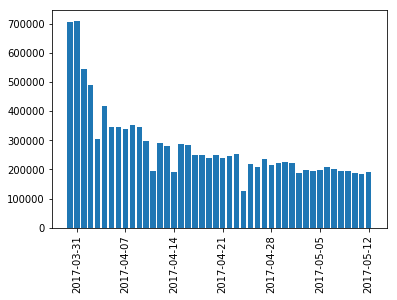

In [205]:
plt.bar(date_count['date'],date_count['count'])
plt.xticks(rotation='vertical')

### check download, play, search behavior respectively

In [206]:
# play behavior
df_play = df.filter(F.col('event') == 'P')
df_play.head(10)

[Row(uid='168551042', event='P', song_id='505355', date=datetime.date(2017, 3, 30)),
 Row(uid='168551430', event='P', song_id='1179220', date=datetime.date(2017, 3, 30)),
 Row(uid='168550728', event='P', song_id='285233', date=datetime.date(2017, 3, 30)),
 Row(uid='168551408', event='P', song_id='15750838', date=datetime.date(2017, 3, 30)),
 Row(uid='168551179', event='P', song_id='23485496', date=datetime.date(2017, 3, 30)),
 Row(uid='168551546', event='P', song_id='1474915', date=datetime.date(2017, 3, 30)),
 Row(uid='168551626', event='P', song_id='8131487', date=datetime.date(2017, 3, 30)),
 Row(uid='168542680', event='P', song_id='0', date=datetime.date(2017, 3, 30)),
 Row(uid='168551166', event='P', song_id='1244660', date=datetime.date(2017, 3, 30)),
 Row(uid='168551166', event='P', song_id='945320', date=datetime.date(2017, 3, 30))]

In [55]:
df_play_date = df_play.groupBy('date').count().toPandas()

In [56]:
df_play_date.head(10)

,date,count
0,2017-04-09,310297
1,2017-05-11,169396
2,2017-04-25,202315
3,2017-04-03,256234
4,2017-04-29,201658
5,2017-05-10,173114
6,2017-05-09,177412
7,2017-04-07,306038
8,2017-04-02,436546
9,2017-04-11,177007


Text(0,0.5,'Number of Play')

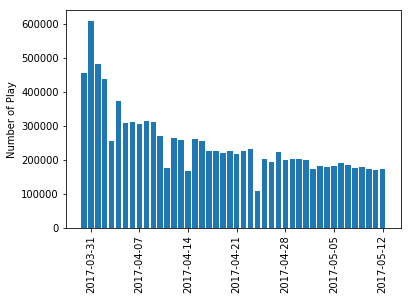

In [69]:
plt.bar(df_play_date['date'],df_play_date['count'])
plt.xticks(rotation='vertical')
plt.ylabel('Number of Play')

In [64]:
# dowload
df_down_date = df.filter(F.col('event') == 'D').groupby('date').count().toPandas()
df_down_date.head(10)

,date,count
0,2017-04-09,13720
1,2017-05-11,4858
2,2017-04-25,6968
3,2017-04-03,20552
4,2017-04-29,8748
5,2017-05-10,6337
6,2017-05-09,7339
7,2017-04-07,14156
8,2017-04-02,23349
9,2017-04-11,7414


Text(0,0.5,'Number of Download')

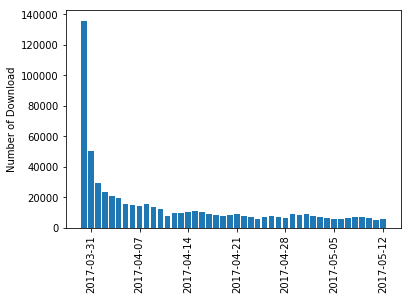

In [70]:
plt.bar(df_down_date['date'],df_down_date['count'])
plt.xticks(rotation='vertical')
plt.ylabel('Number of Download')

In [68]:
# search
df_search_date = df.filter(F.col('event') == 'S').groupby('date').count().toPandas()
df_search_date.head(10)

,date,count
0,2017-04-09,20186
1,2017-05-11,9865
2,2017-04-25,8855
3,2017-04-03,26699
4,2017-04-29,12724
5,2017-05-10,9571
6,2017-05-09,10489
7,2017-04-07,19431
8,2017-04-02,29936
9,2017-04-11,10152


Text(0,0.5,'Number of Search')

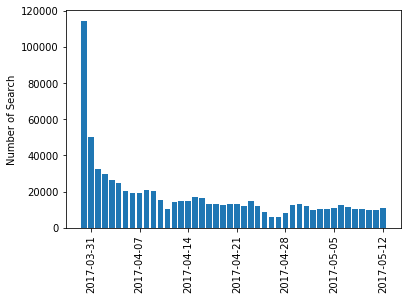

In [71]:
plt.bar(df_search_date['date'],df_search_date['count'])
plt.xticks(rotation='vertical')
plt.ylabel('Number of Search')
# continue decreasing

# Label definition

In [67]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date= parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window:',label_window_start_date,'~',label_window_end_date,'days:',label_window_size)

feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date  - datetime.timedelta(feature_window_size - 1)
print('feature window:',feature_window_start_date,'~',feature_window_end_date,'days:',feature_window_size)

label window: 2017-04-29 ~ 2017-05-12 days: 14
feature window: 2017-03-30 ~ 2017-04-28 days: 30


In [68]:
tmp = parser.parse('2017-05-12')
tmp,label_window_end_date

(datetime.datetime(2017, 5, 12, 0, 0), datetime.date(2017, 5, 12))

In [69]:
# timedelta() A duration expressing the difference between two date, time, 
# or datetime instances to microsecond resolution.
datetime.timedelta()

datetime.timedelta(0)

#### Only consider uids that were logged/active in feature window
df_model_uid contains the users who were active in feature window

In [70]:
# all the uid we will model
df_model_uid = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))\
                    .select('uid').distinct()

In [71]:
df_model_uid.count()

58184

### Define churn

If one user was active in former 30 days (have log in feature window) and inactive in the later 14 days (no logs of uid in label window),
then the user is regarded as churned.

In [72]:
# active in label window (active label=0)
# logged in feature window means active, lable = 0
df_active_uid_in_label_window = df.filter((F.col('date')>=label_window_start_date) & (F.col('date')<=label_window_end_date))\
                            .select('uid').distinct().withColumn('label',F.lit(0))

#F.lit() Creates a Column of literal value.

In [73]:
df_active_uid_in_label_window.count(),\
df_active_uid_in_label_window.count()/df_model_uid.count(),\
1- (df_active_uid_in_label_window.count()/df_model_uid.count())

(23224, 0.3991475319675512, 0.6008524680324487)

The percentage of active user in label window is 39.91%, that is to say, churn rate is 60.09%.

#### prepare label data (churn label=1; active label=0)
Left join active user in label window dataframe to full dataset, then the label of joined dataframe will be null value. Then fill the null value with 1 (churn).

In [74]:
# prepare label data (churn label=1; active label=0)
df_label = df_model_uid.join(df_active_uid_in_label_window,on=['uid'],how ='left')

In [75]:
df_label.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
| null|36187|
|    0|21997|
+-----+-----+



In [76]:
df_label = df_label.fillna(1)

In [77]:
df_label.show()

+---------+-----+
|      uid|label|
+---------+-----+
|148413435|    0|
|154708890|    1|
|166351678|    1|
|166601616|    0|
|167570656|    1|
|167571423|    0|
|167579073|    1|
|167587629|    1|
|167589113|    1|
|167601016|    1|
|167606196|    1|
|167631789|    1|
|167640783|    1|
|167666341|    1|
|167669429|    1|
|167672887|    0|
|167673619|    0|
|167684710|    1|
|167688259|    0|
|167690867|    0|
+---------+-----+
only showing top 20 rows



In [78]:
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|36187|
|    0|21997|
+-----+-----+



In [79]:
df_label.filter(F.col('label') == 0).count()/df_label.count()

0.37805926027773956

# Feature generation

In [80]:
# event_data in feature_window
df_feature_window = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))

In [30]:
#df_feature_window.show()

### Frequency features

##### method 1

In [81]:
# define a function to generate frequency features
# snapshot_date is the last day of time_window
def frequency_feature_generation(df,event,time_window,snapshot_date):
    """
    generate frequency features for one event type and one time window
    """
    df_feature = df.filter(F.col('event')== event)\
            .filter((F.col('date')>=snapshot_date-datetime.timedelta(time_window - 1)) & (F.col('date')<=snapshot_date))\
            .groupBy('uid').agg(F.count(F.col('uid')).alias('freq_'+event+'_last_'+str(time_window)))
    return df_feature

In [82]:
# generate one feature
# for example: frequency of search in last 3 days in feature window 
event = 'S'
time_window = 3
snapshot_date = feature_window_end_date
df_freq_feature = frequency_feature_generation(df_feature_window,event,time_window,snapshot_date)

In [83]:
df_freq_feature.show(5)

+---------+-------------+
|      uid|freq_S_last_3|
+---------+-------------+
|167973428|            2|
|167935507|           10|
|167958940|            4|
|168079950|           23|
|168464445|            2|
+---------+-------------+
only showing top 5 rows



In [84]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
df_freq_feature_list = []
for event in event_list:
    for time_window in time_window_list:
        df_freq_feature_list.append(frequency_feature_generation(df_feature_window,event,time_window,snapshot_date))


In [85]:
df_freq_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint],
 DataFrame[uid: string, freq_P_last_3: bigint],
 DataFrame[uid: string, freq_P_last_7: bigint],
 DataFrame[uid: string, freq_P_last_14: bigint],
 DataFrame[uid: string, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint],
 DataFrame[uid: string, freq_D_last_3: bigint],
 DataFrame[uid: string, freq_D_last_7: bigint],
 DataFrame[uid: string, freq_D_last_14: bigint],
 DataFrame[uid: string, freq_D_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint],
 DataFrame[uid: string, freq_S_last_3: bigint],
 DataFrame[uid: string, freq_S_last_7: bigint],
 DataFrame[uid: string, freq_S_last_14: bigint],
 DataFrame[uid: string, freq_S_last_30: bigint]]

##### method 2: too many dfs to join? do it another way
To join too many dataframes is time consuming,
we have to limit the times to join the dataframe
#list of operations is an advanced operation

In [86]:
# define a function to generate frequency features for a list of time windows
# using when().otherwise(), and list comprehension trick!
def frequency_feature_generation_time_windows(df,event,time_window_list,snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df \
        .filter(F.col('event')==event) \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) & (F.col('date')<=snapshot_date),1).otherwise(0)).alias('freq_'+event+'_last_'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature



In [87]:
# generate one event type, all time windows 
event = 'S'
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_freq_feature = frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date)
df_freq_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|167993779|            0|            0|            1|             6|            56|
|167935507|            6|           10|           33|            91|           222|
|167672887|            0|            0|            0|             0|             3|
|167955727|            9|            9|            9|            33|            70|
|168025511|            0|            0|            0|             0|             3|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



In [88]:
# generate frequency features for all event_list, time_window_list
event_list = ['P','D','S']
time_window_list = [1,3,7,14,30]
df_freq_feature_list = []
for event in event_list:
    df_freq_feature_list.append(frequency_feature_generation_time_windows(df_feature_window,event,time_window_list,snapshot_date))


In [89]:
df_freq_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint]]

### Recency features

In [90]:
# event_data in feature_window
df_feature_window = df.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))
#df_feature_window.show()

In [91]:
# define function to get days from end to start
#def subtract_snapshot_date(last_event_date):
#    return (snapshot_date.date() - last_event_date).days

#udf_subtract_snapshot_date = F.udf(subtract_snapshot_date, IntegerType())

# define a function to generate recency features
# snapshot_date is the last day of time_window

#def recency_feature_generation(df,event,snapshot_date):
#    """
#    generate recency features for one event type
#    get days between last event time from snapshot time
#    """
#    df_recency_feature = df.filter(F.col('event')== event)\
#            .groupBy('uid').agg(F.max('date').alias('max_event_date'))\
#                .withColumn('recency',F.datediff(snapshot_date,F.col('max_event_date'))
                            
#    return df_recency_feature

#### Define a function to generate recency features

In [92]:
# define a function to generate recency features
# snapshot_date is the last day of time_window
def recency_feature_generation(df,event,snapshot_date):
    """
    generate recency features for one event type
    get days between last event time from snapshot time
    """
    df_daysbefore = df.filter(F.col('event')== event)\
                    .withColumn('days_before_snapshot',F.datediff(F.lit(snapshot_date),'date'))
    
    df_recency_feature = df_daysbefore.groupBy('uid').\
                        agg(F.min('days_before_snapshot').alias('recency_' + event))
                            
    return df_recency_feature


#### Search
The number of users who searched at least one time is 33310

In [43]:
event = 'S'
snapshot_date = feature_window_end_date
df_recency_S_tmp = recency_feature_generation(df_feature_window,event,snapshot_date)

In [573]:
df_recency_S_tmp.select('uid').distinct().count()

33310

#### Play
The number of users who play at least one time is 58061

In [574]:
event = 'P'
snapshot_date = feature_window_end_date
df_recency_P_tmp = recency_feature_generation(df_feature_window,event,snapshot_date)

In [575]:
df_recency_P_tmp.select('uid').distinct().count()

58061

#### Download
The number of users who download at least one time is 22876

In [579]:
event = 'D'
snapshot_date = feature_window_end_date
df_recency_D_tmp = recency_feature_generation(df_feature_window,event,snapshot_date)

In [580]:
df_recency_D_tmp.select('uid').distinct().count()

22876

Either play, download or search behavior of one user in feature window will be included in model

In [93]:
# generate recency features for all event
event_list = ['P','D','S']
df_recency_feature_list = []
for event in event_list:
    df_recency_feature_list.append(recency_feature_generation(df_feature_window,event,snapshot_date))




In [94]:
df_recency_feature_list

[DataFrame[uid: string, recency_P: int],
 DataFrame[uid: string, recency_D: int],
 DataFrame[uid: string, recency_S: int]]

### Acceleration features
- Ratio of event frequency of different time window is used to measure acceleration.
- It could capture possible trend in user behavior, for example, if freq_play_last_1/avg_freq_play_last_7 > 1, then the user played more frequently.
- To measuring relative long term acceleration, freq_play_last_1/avg_freq_play_last_30

In [107]:
def join_feature_data(df_master,df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master

In [108]:
# frequency datafram
df_freq = join_feature_data(df_label,df_freq_feature_list)

In [109]:
# df_freq.count()
# 58184
df_acc_feature_tmp1 = df_freq.withColumn('acc_P_1_7', F.col('freq_P_last_1')*7/F.col('freq_P_last_7'))

In [110]:
df_acc = df_freq\
.withColumn('acc_P_1_7', (F.col('freq_P_last_1')/1)/(F.col('freq_P_last_7')/7))\
.withColumn('acc_P_7_14', (F.col('freq_P_last_7')/7)/(F.col('freq_P_last_14')/14))\
.withColumn('acc_P_14_30', (F.col('freq_P_last_14')/14)/(F.col('freq_P_last_30')/30))\
.withColumn('acc_P_D_1_7', (F.col('freq_P_last_1')/1)/ (F.col('freq_D_last_7')/7))\
.withColumn('acc_D_1_7', (F.col('freq_D_last_1')/1)/(F.col('freq_D_last_7')/7))\
.withColumn('acc_D_7_14', (F.col('freq_D_last_7')/7)/(F.col('freq_D_last_14')/14))\
.withColumn('acc_D_14_30', (F.col('freq_D_last_14')/14)/(F.col('freq_D_last_30')/30))\
.withColumn('acc_S_1_7', (F.col('freq_S_last_1')/1)/(F.col('freq_S_last_7')/7))\
.withColumn('acc_S_7_14', (F.col('freq_S_last_7')/7)/(F.col('freq_S_last_14')/14))\
.withColumn('acc_S_14_30', (F.col('freq_S_last_14')/14)/(F.col('freq_S_last_30')/30))

            

            

In [112]:
drop_list = ['label','freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30'] 

for col in drop_list:
    df_acc = df_acc.drop(col)

In [115]:
df_acc.columns

['uid',
 'acc_P_1_7',
 'acc_P_7_14',
 'acc_P_14_30',
 'acc_P_D_1_7',
 'acc_D_1_7',
 'acc_D_7_14',
 'acc_D_14_30',
 'acc_S_1_7',
 'acc_S_7_14',
 'acc_S_14_30']

### Profile features

### Play behavior

In [95]:
df_play = spark.read.csv('/Users/xuejiwang/Documents/dev/MusicBox/data/play/play_ds.csv',header=True)
df_play.show(5)

+---------+------+--------+----------+--------------------+-----------+
|      uid|device| song_id|      date|           play_time|song_length|
+---------+------+--------+----------+--------------------+-----------+
|168551042|    ar|  505355|2017-03-30|                 106|        277|
|168551430|    ar| 1179220|2017-03-30|                 231|        231|
|168550728|    ar|  285233|2017-03-30|                 282|        282|
|168551408|    ar|15750838|2017-03-30|7>(123.138.230.80)TM|          0|
|168551179|    ar|23485496|2017-03-30|                  26|        212|
+---------+------+--------+----------+--------------------+-----------+
only showing top 5 rows



In [96]:
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))
df_profile_tmp = df_play_feature_window.select('uid','device').distinct()

In [97]:
df_profile_tmp.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|    mc|    1|
|    ar|50852|
|    wp|    1|
|    ip| 7222|
+------+-----+



In [95]:
# check if one user has two devices
df_profile_tmp.count()

58076

In [96]:
df_profile_tmp.distinct().count()

58076

In [56]:
df_profile_tmp = df_profile_tmp.withColumn('device_type',F.when(F.col('device')=='ip',1).otherwise(2))
df_profile_tmp.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 7222|
|          2|50854|
+-----------+-----+



In [57]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid','device_type'),on='uid',how='left')
df_profile.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|       null|  123|
|          1| 7222|
|          2|50854|
+-----------+-----+



In [458]:
df_profile.show()

+---------+-----------+
|      uid|device_type|
+---------+-----------+
|148413435|          2|
|154708890|          2|
|166351678|          2|
|166601616|          2|
|167570656|          2|
|167571423|          2|
|167579073|          1|
|167587629|          2|
|167589113|          2|
|167601016|          2|
|167606196|          2|
|167631789|          2|
|167640783|          2|
|167666341|          2|
|167669429|          2|
|167672887|          2|
|167673619|          2|
|167684710|          2|
|167688259|          2|
|167690867|          1|
+---------+-----------+
only showing top 20 rows



#### Total play time features

In [ ]:
# Can you generate total song play time features (using play_ds data) for different time window
# using play data (need to clean play time first, play time may be negative in data)
df_play_feature_window = df_play.filter((F.col('date')>=feature_window_start_date) & (F.col('date')<=feature_window_end_date))
df_play_feature_window.filter(F.col('play_time') < 0).show()

In [65]:
df_play_feature_window_filtered = df_play_feature_window.filter(F.col('play_time') >= 0)

In [98]:
def tot_playtime_feature_generation(df,time_window_list,snapshot_date):
    """
    generate total playtime for a list of time windows
    """
    df_feature = df \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date),1).otherwise(0))\
               .alias('tot_playtime_last_' + str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature


In [105]:
time_window_list = [1,3,7,14,30]
snapshot_date = feature_window_end_date
df_tot_playtime = tot_playtime_feature_generation(df_play_feature_window_filtered,time_window_list, snapshot_date)
df_tot_playtime.show()


+---------+-------------------+-------------------+-------------------+--------------------+--------------------+
|      uid|tot_playtime_last_1|tot_playtime_last_3|tot_playtime_last_7|tot_playtime_last_14|tot_playtime_last_30|
+---------+-------------------+-------------------+-------------------+--------------------+--------------------+
|168554270|                  0|                  0|                  0|                   0|                  25|
|168576985|                  0|                  0|                  0|                   0|                  14|
|168578813|                  0|                  0|                  0|                   0|                  13|
|168579447|                  0|                  0|                  0|                   0|                  45|
|168587753|                  0|                  1|                  4|                  30|                 125|
|168622990|                  0|                  3|                  4|                 

### Fancier frequency features

In [ ]:
# Can you generate counts of songs play 80% of their song length (using play_ds data) for different time window
# using play data (need to clean play time and song length first, play time may be negative in data, song length may be zeros)

In [133]:
def df_80per_song_count_generation(df,time_window_list,snapshot_date):
    """
    generate count of songs that finished 80 percent
    """
    df_feature = df \
        .groupBy('uid') \
        .agg(*[F.sum(F.when((F.col('date')>=snapshot_date-datetime.timedelta(time_window-1)) \
                            & (F.col('date')<=snapshot_date)\
                            &(F.col('play_time')/F.col('song_length') >= 0.8),1).otherwise(0))\
               .alias('count_80per_song_last'+str(time_window)) \
                for time_window in time_window_list]
            )# *[] opens list and make them comma separated
    return df_feature

In [134]:
df_play_feature_window_filtered = df_play_feature_window_filtered.filter(F.col('song_length') > 0)

In [135]:
time_window_list = [1, 3, 7, 14, 30]
df_80per_song = df_80per_song_count_generation(df_play_feature_window_filtered,time_window_list,snapshot_date)
df_80per_song.show()

+---------+----------------------+----------------------+----------------------+-----------------------+-----------------------+
|      uid|count_80per_song_last1|count_80per_song_last3|count_80per_song_last7|count_80per_song_last14|count_80per_song_last30|
+---------+----------------------+----------------------+----------------------+-----------------------+-----------------------+
|168554270|                     0|                     0|                     0|                      0|                     15|
|168576985|                     0|                     0|                     0|                      0|                      9|
|168578813|                     0|                     0|                     0|                      0|                      1|
|168579447|                     0|                     0|                     0|                      0|                      0|
|168587753|                     0|                     1|                     1|                 

In [140]:
[df_80per_song]

[DataFrame[uid: string, count_80per_song_last1: bigint, count_80per_song_last3: bigint, count_80per_song_last7: bigint, count_80per_song_last14: bigint, count_80per_song_last30: bigint]]

###  Download data profile

In [187]:
df_down = spark.read.csv('/Users/xuejiwang/Documents/dev/MusicBox/data/down/down_ds.csv',header=True)
df_down.show(5)

+---------+------+-------+----------+
|      uid|device|song_id|      date|
+---------+------+-------+----------+
|168019810|    ar| 442554|2017-03-30|
|168019810|    ar|6334611|2017-03-30|
|168019810|    ar|9867382|2017-03-30|
|168019810|    ar|6660691|2017-03-30|
|168019810|    ar| 157606|2017-03-30|
+---------+------+-------+----------+
only showing top 5 rows



### Search profile

In [188]:
df_search = spark.read.csv('/Users/xuejiwang/Documents/dev/MusicBox/data/search/search_ds.csv',header=True)
df_search.show(5)

+---------+------+----------+
|      uid|device|      date|
+---------+------+----------+
|167776092|    ar|2017-03-30|
|168317948|    ip|2017-03-30|
|168019810|    ar|2017-03-30|
|167583852|    ip|2017-03-30|
|167972714|    ar|2017-03-30|
+---------+------+----------+
only showing top 5 rows



# Form training data

In [145]:
def join_feature_data(df_master,df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature,on='uid',how='left')
        #df_master.persist() # uncomment if number of joins is too many
    return df_master

### Frequency dataframe

In [187]:
# join all behavior features
df_freq = join_feature_data(df_label,df_freq_feature_list)

In [ ]:
from pyspark.sql.functions import isnan, isnull, when, count, col
df_freq.select([F.count(F.when(isnan(c), c)).alias(c) for c in df_freq.columns]).show()

In [190]:
df_freq.select([F.count(F.when(isnull(c), c)).alias(c) for c in df_freq.columns]).show()

+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+
|uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+
|  0|    0|          123|          123|          123|           123|           123|        35308|        35308|        35308|         35308|         35308|        24874|        24874|        24874|         24874|         24874|
+---+-----+-------------+-------------+-------------+--------------+--------------+-----

In [191]:
# if Frequency is null, then we could take the frequency as 0. There is no event happen of the user in the last n days 
df_freq = df_freq.fillna(0)

### Recency dataframe

In [ ]:
df_recency = join_feature_data(df_label,df_recency_feature_list)

In [192]:
df_recency.select([F.count(F.when(isnull(c), c)).alias(c) for c in df_recency.columns]).show()

+---+-----+---------+---------+---------+
|uid|label|recency_P|recency_D|recency_S|
+---+-----+---------+---------+---------+
|  0|    0|      123|    35308|    24874|
+---+-----+---------+---------+---------+



- null value of recency_P is 123. The number of users didn't play any song in feature window is 123
- null value of recency_S is 24874. The number of users didn't search any song in feature window.
- null value of recency_D is 35308.The number of users didn't download any songs in feature window.

#### Join recency feature to df_freq
##### method 1: left join df_recency to df_freq, if recency is null, fill it with a number larger than 30, try 35.

In [ ]:
df_f_r = join_feature_data(df_freq, df_recency_feature_list)

In [193]:
df_f_r.select([F.count(F.when(isnull(c), c)).alias(c) for c in df_f_r.columns]).show()

+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+
|uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|recency_P|recency_D|recency_S|
+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+
|  0|    0|            0|            0|            0|             0|             0|            0|            0|            0|             0|             0|            0|            0|            0|             0|             0

In [194]:
df_f_r = df_f_r.fillna(35)

#### Join total playtime to frequency and recency

In [154]:
df_f_r_totplay = join_feature_data(df_f_r, [df_tot_playtime])

In [196]:
df_f_r_totplay.select([F.count(F.when(isnull(c), c)).alias(c) for c in df_f_r_totplay.columns]).show()

+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+-------------------+-------------------+-------------------+--------------------+--------------------+
|uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|recency_P|recency_D|recency_S|tot_playtime_last_1|tot_playtime_last_3|tot_playtime_last_7|tot_playtime_last_14|tot_playtime_last_30|
+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+-------------------+---

#### Join 80 percent finised songs number

In [ ]:
df_f_r_totplay_80per = join_feature_data(df_f_r_totplay.fillna(0), [df_80per_song])

In [198]:
df_f_r_totplay_80per.select([F.count(F.when(isnull(c), c)).alias(c) for c in df_f_r_totplay_80per .columns]).show()

+---+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+-------------------+-------------------+-------------------+--------------------+--------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+
|uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|recency_P|recency_D|recency_S|tot_playtime_last_1|tot_playtime_last_3|tot_playtime_last_7|tot_playtime_last_14|tot_playtime_last_30|count_80per_song_last1|count_80per_song_last3|count_80per_song_last7|count_80per_song_last14|count_80per_song_last30|
+---+-----+-------------+-------------+-------

#### Join Profile Feature

In [208]:
df_final = join_feature_data(df_f_r_totplay_80per.fillna(0),[df_profile])

In [210]:
df_final.toPandas().to_csv('/Users/xuejiwang/Documents/dev/MusicBox/data/df_final.csv',index=False)